In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegressionCV
from sklearn import preprocessing
from pycaret.regression import * 

In [2]:
train = pd.read_csv('./train.csv').drop_duplicates()
test = pd.read_csv('./test.csv')
test_ids = pd.read_csv('./test_ids.csv')

In [3]:
train['time_stamp'] = pd.to_datetime(train['time_stamp'])

train.loc[:,'month'] = train.loc[:,'time_stamp'].dt.strftime('%m')
train.loc[:,'dayOfMonth'] = train.loc[:,'time_stamp'].dt.strftime('%d')
train.loc[:,'dayofWeek'] = train.loc[:,'time_stamp'].dt.day_name()
train.loc[:,'hour'] = train.loc[:,'time_stamp'].dt.strftime('%H')
train.loc[:,'date'] = train.loc[:,'time_stamp'].dt.strftime('%Y-%m-%d')
train['hour'] = (train['hour']).astype(int)
train['dayOfMonth'] = (train['dayOfMonth']).astype(int)
train['month'] = (train['month']).astype(int)

train['date'] = train['time_stamp'].dt.date
train['date'] = pd.to_datetime(train['date'])

test['time_stamp'] = pd.to_datetime(test['time_stamp'])

test.loc[:,'month'] = test.loc[:,'time_stamp'].dt.strftime('%m')
test.loc[:,'dayOfMonth'] = test.loc[:,'time_stamp'].dt.strftime('%d')
test.loc[:,'dayofWeek'] = test.loc[:,'time_stamp'].dt.day_name()
test.loc[:,'hour'] = test.loc[:,'time_stamp'].dt.strftime('%H')
test.loc[:,'date'] = test.loc[:,'time_stamp'].dt.strftime('%Y-%m-%d')
test['hour'] = (test['hour']).astype(int)
test['dayOfMonth'] = (test['dayOfMonth']).astype(int)
test['month'] = (test['month']).astype(int)

test['date'] = test['time_stamp'].dt.date
test['date'] = pd.to_datetime(test['date'])

In [6]:
# train filtering
train_filtered = pd.concat([train[train['gender'] == 'M'],train[train['gender'] == 'F'].sample(frac = 0.1944)], axis = 0)
products = train[['Level1_Category_Name',
                          'Level2_Category_Name',
                          'Level3_Category_Name',
                          'product_gender',
                         'contentid',
                         'product_name',
                         'brand_name',
                         'businessunit']].drop_duplicates()

gender_stats = (train_filtered
 .groupby(['Level1_Category_Name',
          'Level2_Category_Name',
          'Level3_Category_Name',
          'businessunit',  
          'product_gender',
           'gender'], dropna = False)
 .agg({"time_stamp": pd.Series.nunique})
 .groupby(['Level1_Category_Name',
          'Level2_Category_Name',
          'Level3_Category_Name',
          'businessunit',
          'product_gender'], dropna = False,
                    as_index=False)
 .apply(lambda x: x / float(x.sum()))
               )
gender_stats = gender_stats.reset_index().fillna('NotDefined')
gender_stats = gender_stats[gender_stats['gender']=='F']

# Change: groupby state_office and divide by sum
product_counts = (products
 .groupby(['Level1_Category_Name',
          'Level2_Category_Name',
          'Level3_Category_Name',
          'businessunit',  
          'product_gender'], dropna = False,
                    as_index=False)
 .agg({ "contentid": pd.Series.nunique})
).fillna('NotDefined')
product_counts.columns = ['Level1_Category_Name',
          'Level2_Category_Name',
          'Level3_Category_Name',
          'businessunit',  
          'product_gender',
          'product_count']

def generate_data(train_filtered, cols):
    gender_stats = (train_filtered
     .groupby(cols, dropna = False)
     .agg({"time_stamp": pd.Series.nunique})
     .groupby(cols[0:len(cols)-1], dropna = False,
                        as_index=False)
     .apply(lambda x: x / float(x.sum()))
                   )
    gender_stats = gender_stats.reset_index().fillna('NotDefined')
    gender_stats = gender_stats[gender_stats['gender']=='F'].drop(columns=['gender'])
    col_name = "1"
    for i in range(len(cols[0:len(cols)-2])):
            col_name = col_name + "_" + cols[i].split("_")[0]
    gender_stats.rename({'time_stamp': col_name}, axis=1, inplace=True)
    return gender_stats


cols = ['businessunit',
        'Level1_Category_Name',
        'Level2_Category_Name',
        'Level3_Category_Name',
        'product_gender',
        'gender']

for i in range(len(cols)):   
    if len(cols) == 2:
        break
    print(i)
    j_data = generate_data(train_filtered, cols)
    product_counts = pd.merge(product_counts, j_data, on = cols[0:len(cols)-1], how = 'left')
    cols.remove(cols[len(cols)-3])
    
cols = [
        'Level1_Category_Name',
        'Level2_Category_Name',
        'Level3_Category_Name',
        'businessunit',
        'product_gender',
        'gender']

for i in range(len(cols)):  
    cols.remove(cols[len(cols)-3])
    if len(cols) == 2:
        break
    print(i)
    j_data = generate_data(train_filtered, cols)
    product_counts = pd.merge(product_counts, j_data, on = cols[0:len(cols)-1], how = 'left')
    
    

def generate_counts(products, cols):
    product_counts = (products
             .groupby(cols[0:len(cols)-1], dropna = False,
                                as_index=False)
             .agg({ "contentid": pd.Series.nunique})
            ).fillna('NotDefined')
    product_counts.columns = cols
    col_name = "count"
    for i in range(len(cols[0:len(cols)-2])):
            col_name = col_name + "_" + cols[i].split("_")[0]
    product_counts.rename({'product_count': col_name}, axis=1, inplace=True)
    return product_counts

cols = [
        'Level1_Category_Name',
        'Level2_Category_Name',
        'Level3_Category_Name',
        'businessunit',
        'product_gender',
        'product_count']

for i in range(len(cols)):  
    cols.remove(cols[len(cols)-3])
    if len(cols) == 2:
        break
    print(i)
    j_data = generate_counts(products, cols)
    product_counts = pd.merge(product_counts, j_data, on = cols[0:len(cols)-1], how = 'left')
    

0
1
2
3
0
1
2
0
1
2


In [8]:
# transactional data
transaction_counts = (train
 .groupby(products.columns.tolist(), dropna = False,
                    as_index=False)
 .agg({"time_stamp": pd.Series.nunique})
)

transaction_counts_by_transaction = (train
 .groupby(products.columns.tolist() + ['user_action'], dropna = False,
                    as_index=False)
 .agg({"time_stamp": pd.Series.nunique})
)
transaction_counts_by_transaction.product_gender = transaction_counts_by_transaction.product_gender.fillna("NotDefined")

transaction_counts_by_transaction = transaction_counts_by_transaction.pivot_table('time_stamp', products.columns.tolist() , 'user_action')
transaction_counts_by_transaction.reset_index( drop=False, inplace=True ) 

transaction_counts_by_transaction = transaction_counts_by_transaction[products.columns.tolist() + ['basket', 'favorite', 'order', 'search', 'visit']]

transaction_counts_by_transaction = transaction_counts_by_transaction.fillna(0)

transaction_counts_by_transaction['total_transaction'] = (transaction_counts_by_transaction['basket'] + 
                                    transaction_counts_by_transaction['favorite'] +
                                    transaction_counts_by_transaction['search'] +
                                    transaction_counts_by_transaction['visit'] +
                                    transaction_counts_by_transaction['order'] )

#products_filtered = transaction_counts_by_transaction[transaction_counts_by_transaction['total_transaction'] > 20]

product_stats = (train_filtered
 .groupby(['contentid',
           'gender'], dropna = False)
 .agg({"time_stamp": pd.Series.nunique})
 .groupby(['contentid'], dropna = False,
                    as_index=False)
 .apply(lambda x: x / float(x.sum()))
               )
product_stats = product_stats.reset_index().fillna('NotDefined')
product_stats = product_stats[product_stats['gender']=='F'].drop(columns=['gender'])

prod_data = pd.merge(transaction_counts_by_transaction, product_stats, on ='contentid', how= 'left')

merged_data = pd.merge(prod_data, product_counts, on =['Level1_Category_Name',
          'Level2_Category_Name',
          'Level3_Category_Name',
          'businessunit',  
          'product_gender'], how= 'left')

In [15]:
from sklearn import preprocessing
merged_data.replace([np.inf, -np.inf], np.nan, inplace=True)
X = merged_data.drop(columns = products.columns.tolist()).fillna(0)

scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)

In [46]:
transaction_counts_by_transaction

user_action,Level1_Category_Name,Level2_Category_Name,Level3_Category_Name,product_gender,contentid,product_name,brand_name,businessunit,basket,favorite,order,search,visit,total_transaction
0,Aksesuar,Aksesuar Set,Aksesuar Set,NotDefined,3662691.0,Erkek Hediye Seti,All Takı,Diğer Aksesuarlar,0.0,0.0,0.0,0.0,3.0,3.0
1,Aksesuar,Aksesuar Set,Aksesuar Set,NotDefined,26199859.0,Avangarde Silver Cüzdan Kemer Kartlık 3 Lü Set...,Çeyiz Diyarı,Ev Dekorasyon,0.0,0.0,0.0,0.0,3.0,3.0
2,Aksesuar,Aksesuar Set,Aksesuar Set,NotDefined,26207659.0,Avangarde Gold Cüzdan Kemer 2li Set Siyah,Çeyiz Diyarı,Ev Dekorasyon,1.0,0.0,0.0,5.0,9.0,15.0
3,Aksesuar,Aksesuar Set,Aksesuar Set,NotDefined,32584676.0,Gri Kemer Cüzdan Kartvizit Tesbih Hediye Seti ...,Forentina,Diğer Aksesuarlar,0.0,0.0,0.0,1.0,1.0,2.0
4,Aksesuar,Aksesuar Set,Aksesuar Set,NotDefined,37707059.0,"Endoles Ametist Ham Taş, Mineral 603184",Endoles Doğal Taş,Mücevher,0.0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
482159,Yaşam,Otomobil & Motosiklet,Otomobil,Unisex,65749529.0,Xmd-3069 Oval 6x9 Midrange 300w 150rms,For-X,Oto Aksesuar,0.0,1.0,0.0,1.0,0.0,2.0
482160,Yaşam,Otomobil & Motosiklet,Otomobil,Unisex,65851330.0,Hyundai Accent Era Kalorifer Radyatörü,MAHER,Oto Aksesuar,0.0,0.0,0.0,1.0,0.0,1.0
482161,Yaşam,Otomobil & Motosiklet,Otomobil,Unisex,65919743.0,Opel Corsa D Android Multimedya Ekran Navigasy...,My Way,Oto Aksesuar,0.0,0.0,0.0,1.0,1.0,2.0
482162,Yaşam,Otomobil & Motosiklet,Otomobil,Unisex,66092541.0,Mobilya Kaplama Folyosu Mat Siyah Folyo 61 Cm ...,Newdizayn,Oto Aksesuar,0.0,0.0,0.0,1.0,0.0,1.0


Note: you may need to restart the kernel to use updated packages.


In [20]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from kneed import KneeLocator



kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}
# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(X_scaled)
    sse.append(kmeans.inertia_)

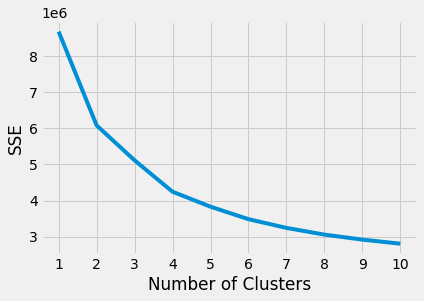

In [21]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [22]:
kl = KneeLocator(
     range(1, 11), sse, curve="convex", direction="decreasing"
 )

In [23]:
kl.elbow

4

In [24]:
    
kmeans = KMeans(
    init="random",
    n_clusters=kl.elbow,
    n_init=10,
    max_iter=300,
    random_state=42
)

In [25]:
kmeans.fit(X_scaled)

KMeans(init='random', n_clusters=4, random_state=42)

In [45]:
pd.concat([merged_data, pd.DataFrame(kmeans.labels_, columns = ["cluster"])], axis = 1).groupby(["cluster" ]).size()

cluster
0    127944
1    127518
2      2103
3    224599
dtype: int64

In [43]:
pd.concat([merged_data, pd.DataFrame(kmeans.labels_, columns = ["cluster"])], axis = 1).groupby(["cluster","Level1_Category_Name" ]).size()

cluster  Level1_Category_Name    
0        Aksesuar                      129
         Ayakkabı                    12370
         Ev & Mobilya                16157
         Giyim                       99288
1        Aksesuar                    12446
         Anne & Bebek & Çocuk          188
         Ayakkabı                    17707
         Elektronik                  21226
         Ev & Mobilya                 1940
         Giyim                       43426
         Kozmetik & Kişisel Bakım     1031
         Spor & Outdoor               8381
         Süpermarket                  9777
         Yaşam                       11396
2        Aksesuar                      108
         Anne & Bebek & Çocuk            9
         Ayakkabı                      182
         Elektronik                    110
         Ev & Mobilya                  353
         Giyim                         998
         Kozmetik & Kişisel Bakım      158
         Spor & Outdoor                 21
         Süpermarket

In [42]:
pd.concat([merged_data, pd.DataFrame(kmeans.labels_, columns = ["cluster"])], axis = 1).head(500)

,Level1_Category_Name,Level2_Category_Name,Level3_Category_Name,product_gender,contentid,product_name,brand_name,businessunit,basket,favorite,order,search,visit,total_transaction,time_stamp,product_count,1_businessunit_Level1_Level2_Level3,1_businessunit_Level1_Level2,1_businessunit_Level1,1_businessunit,1_Level1_Level2_Level3,1_Level1_Level2,1_Level1,count_Level1_Level2_Level3,count_Level1_Level2,count_Level1,cluster
0,Aksesuar,Aksesuar Set,Aksesuar Set,NotDefined,3662691.0,Erkek Hediye Seti,All Takı,Diğer Aksesuarlar,0.0,0.0,0.0,0.0,3.0,3.0,NaN,5,0.111111,0.111111,0.842857,0.597285,0.170732,0.170732,0.695796,33,33,831,1
1,Aksesuar,Aksesuar Set,Aksesuar Set,NotDefined,26199859.0,Avangarde Silver Cüzdan Kemer Kartlık 3 Lü Set...,Çeyiz Diyarı,Ev Dekorasyon,0.0,0.0,0.0,0.0,3.0,3.0,NaN,2,NaN,NaN,NaN,0.596117,0.170732,0.170732,0.695796,33,33,831,1
2,Aksesuar,Aksesuar Set,Aksesuar Set,NotDefined,26207659.0,Avangarde Gold Cüzdan Kemer 2li Set Siyah,Çeyiz Diyarı,Ev Dekorasyon,1.0,0.0,0.0,5.0,9.0,15.0,NaN,2,NaN,NaN,NaN,0.596117,0.170732,0.170732,0.695796,33,33,831,1
3,Aksesuar,Aksesuar Set,Aksesuar Set,NotDefined,32584676.0,Gri Kemer Cüzdan Kartvizit Tesbih Hediye Seti ...,Forentina,Diğer Aksesuarlar,0.0,0.0,0.0,1.0,1.0,2.0,1.000000,5,0.111111,0.111111,0.842857,0.597285,0.170732,0.170732,0.695796,33,33,831,1
4,Aksesuar,Aksesuar Set,Aksesuar Set,NotDefined,37707059.0,"Endoles Ametist Ham Taş, Mineral 603184",Endoles Doğal Taş,Mücevher,0.0,0.0,0.0,1.0,0.0,1.0,NaN,10,0.142857,0.142857,0.800000,0.800000,0.170732,0.170732,0.695796,33,33,831,1
5,Aksesuar,Aksesuar Set,Aksesuar Set,NotDefined,37866520.0,Erkek Kemer Cüzdan Set Deri Erkek Cüzdan Ve Kemer,Mevsim Deri,Mücevher,0.0,0.0,0.0,0.0,2.0,2.0,NaN,10,0.142857,0.142857,0.800000,0.800000,0.170732,0.170732,0.695796,33,33,831,1
6,Aksesuar,Aksesuar Set,Aksesuar Set,NotDefined,38143728.0,Kemer Delme Pensesi,HAYATINIZI KOLAYLAŞTIRIN,Mücevher,0.0,0.0,0.0,1.0,0.0,1.0,NaN,10,0.142857,0.142857,0.800000,0.800000,0.170732,0.170732,0.695796,33,33,831,1
7,Aksesuar,Aksesuar Set,Aksesuar Set,NotDefined,39499915.0,Anneler Günü Hediye Seti Siyah Bayan Cüzdan Pa...,HediyeSet,Mücevher,0.0,0.0,0.0,1.0,0.0,1.0,NaN,10,0.142857,0.142857,0.800000,0.800000,0.170732,0.170732,0.695796,33,33,831,1
8,Aksesuar,Aksesuar Set,Aksesuar Set,NotDefined,39575478.0,Silver Metal Hasır Kordon Sevgili Kombin Çift ...,Ricardo,Saat B,0.0,0.0,0.0,0.0,1.0,1.0,NaN,1,NaN,NaN,0.333333,0.400000,0.170732,0.170732,0.695796,33,33,831,1
9,Aksesuar,Aksesuar Set,Aksesuar Set,NotDefined,47419845.0,Erkek Turuncu Çiçekli Kutulu Kravat Mendil Kol...,Exve Exclusive,Diğer Aksesuarlar,0.0,0.0,0.0,1.0,1.0,2.0,NaN,5,0.111111,0.111111,0.842857,0.597285,0.170732,0.170732,0.695796,33,33,831,1


In [44]:
pd.concat([merged_data, pd.DataFrame(kmeans.labels_, columns = ["cluster"])], axis = 1).to_csv( "product_clusters.csv")

'1_ '